https://github.com/xiaoyuxie-vico/Sci-ML-Book/blob/main/FNO/FNO-1D/FNO-1D.ipynb

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

def is_running_on_colab():
    return 'COLAB_GPU' in os.environ

# Use the function to check
if is_running_on_colab():
    from google.colab import drive
    print("This notebook is running on Google Colab.")
    
    # Mount your Google Drive.
    drive.mount("/content/drive")
    
    # check whether the dataset is already in your google drive or local computer
    # make sure burgers_data_R10.mat is in this folder of your google drive
    !ls /content/drive/MyDrive/Dataset
    
    # used for Colab. You need to change the path for your file
    dataset_path = '/content/drive/MyDrive/Dataset/burgers_data_R10.mat' 
else:
    print("This notebook is not running on Google Colab.")
    dataset_path = 'burgers_data_R10.mat' # put the dataset in a relative path

This notebook is not running on Google Colab.


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

# print pytorch version and cuda version
print(torch.__version__, device)

2.1.1+cu118 cuda


In [3]:
raw_data = np.load('1D_Burger.npz')
A = raw_data['a']
U = raw_data['u']

N, L = A.shape

# 1D grid
X = np.tile(np.linspace(0, 1, L), (N,1))

In [4]:
downsample_rate = 32

A_sampled = A[:, ::downsample_rate]
U_sampled = U[:, ::downsample_rate]
X_sampled = X[:, ::downsample_rate]

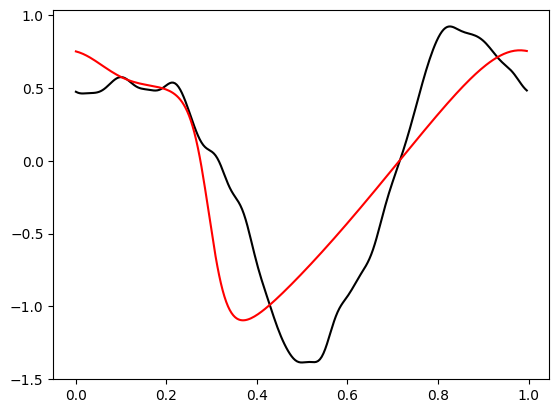

In [5]:
i = 1
plt.plot(X_sampled[i,:], A_sampled[i,:], color='black')
plt.plot(X_sampled[i,:], U_sampled[i,:], color='red')

In [6]:
A_sampled = np.expand_dims(A_sampled, -1)
X_sampled = np.expand_dims(X_sampled, -1)
U_sampled = np.expand_dims(U_sampled, -1)

data = torch.cat([torch.Tensor(X_sampled), torch.Tensor(A_sampled), torch.Tensor(U_sampled)], dim=2)
data.shape

torch.Size([2048, 256, 3])

In [7]:
N_train = int(0.7*N)
N_val = int(0.15*N)
N_test = int(0.15*N)

train_data, val_data, test_data = data[:N_train, :, :], data[N_train:N_train+N_val, :, :], data[-N_test:, :, :]

train_data.shape, val_data.shape, test_data.shape

(torch.Size([1433, 256, 3]),
 torch.Size([307, 256, 3]),
 torch.Size([307, 256, 3]))

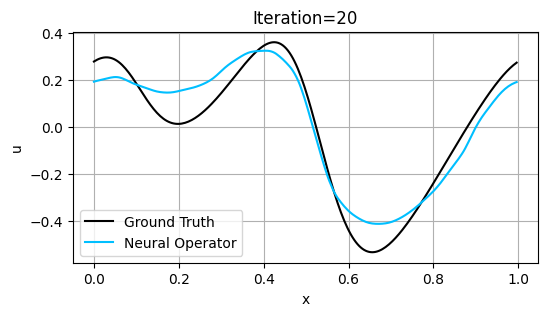

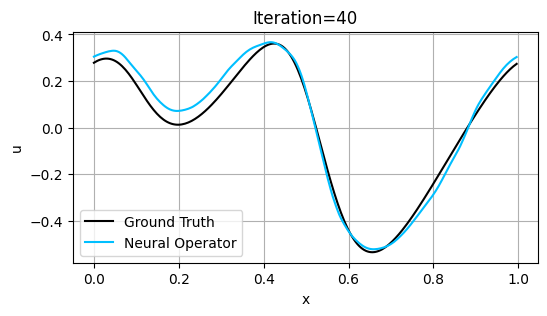

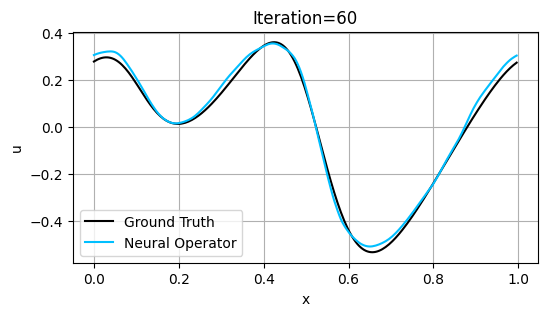

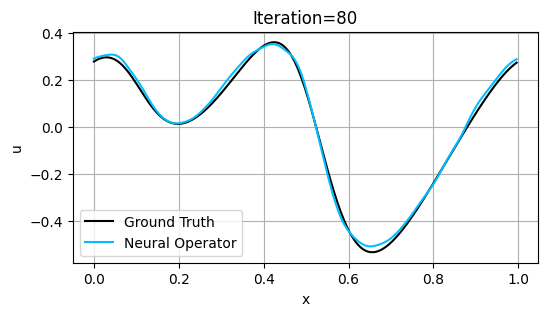

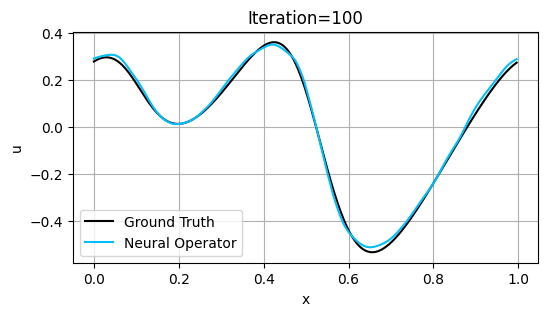

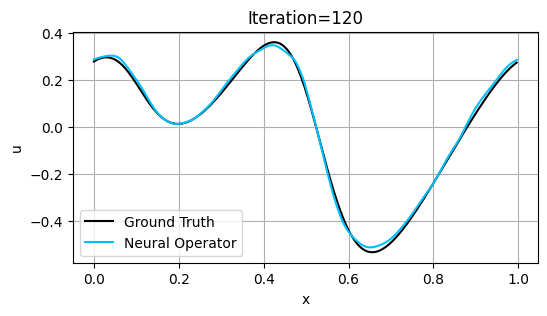

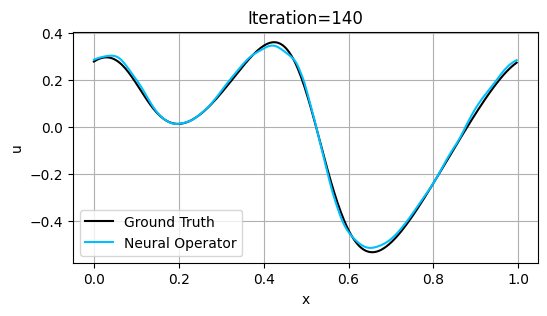

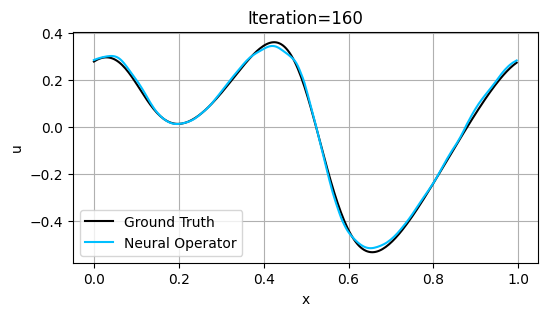

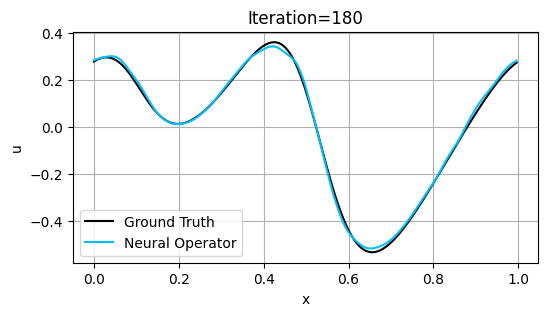

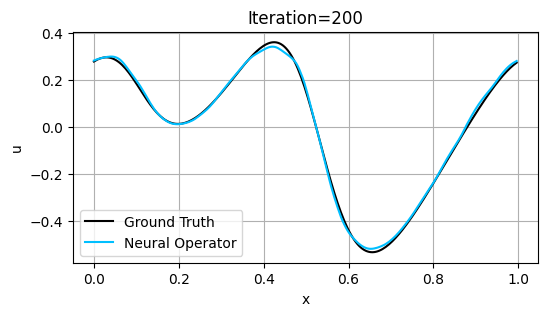

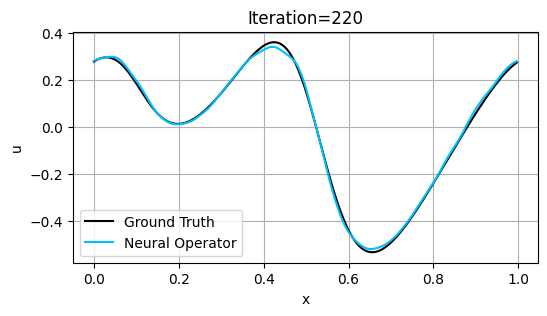

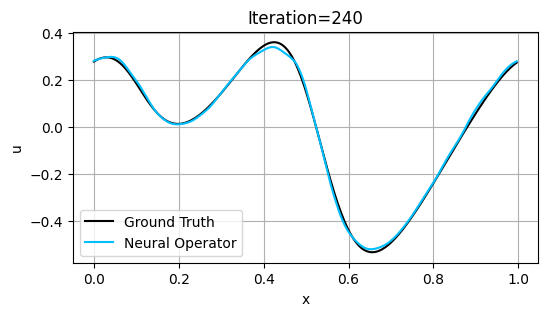

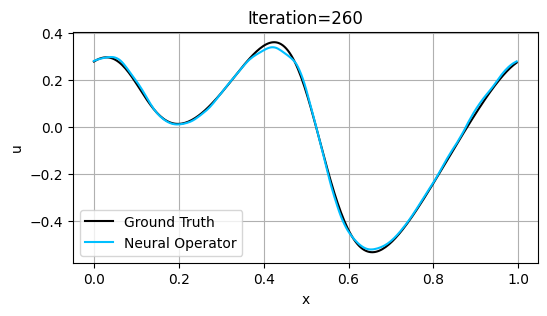

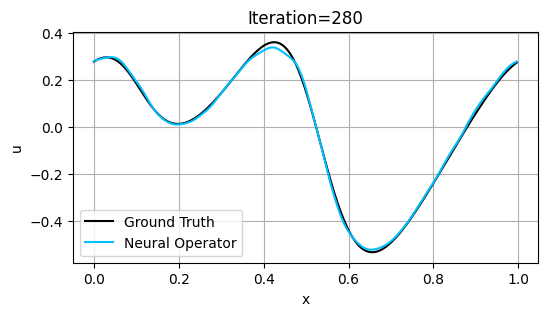

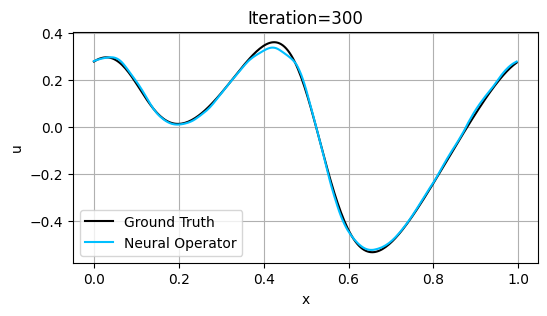

In [26]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))


    def forward(self, x):
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft(x)  # [Batch, C_in, Nx] -> [Batch, C_in, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        # [Batch, C_in, self.modes] * [C_in, C_out, self.modes] -> [Batch, C_out, self.modes]
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)  

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))  # [Batch, C_out, self.modes] -> [Batch, C_out, Nx], eg. [20, 64, 65] -> [20, 64, 128]
        return x
    

class FNO1d(nn.Module):
    def __init__(self, width):
        super(FNO1d, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (x, a(x)) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, 16)
        self.conv1 = SpectralConv1d(self.width, self.width, 16)
        self.conv2 = SpectralConv1d(self.width, self.width, 16)
        self.conv3 = SpectralConv1d(self.width, self.width, 16)

        self.skip0 = nn.Conv1d(self.width, self.width, 1)
        self.skip1 = nn.Conv1d(self.width, self.width, 1)
        self.skip2 = nn.Conv1d(self.width, self.width, 1)
        self.skip3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        x = self.skip0(x) + self.conv0(x)
        x = nn.SiLU()(x)

        x = self.skip1(x) + self.conv1(x)
        x = nn.SiLU()(x)

        x = self.skip2(x) + self.conv2(x)
        x = nn.SiLU()(x)

        x = self.skip3(x) + self.conv3(x)
        x = nn.SiLU()(x)

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, C], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]
        
        # since there are only one output
        x = x.squeeze(-1)       # [Batch, Nx, 1] -> [Batch, Nx], eg. [20, 128, 1] -> [20, 128]
        
        return x
    

model = FNO1d(width=64)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

files = []
import os
save_dir = 'results/neural_operators/1d_burger'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
   
MAX_ITER = 300
for iter in range(MAX_ITER):
    lr_scheduler.step()

    optimizer.zero_grad()
    prediction = model(train_data[:,:,:2])
    loss = torch.mean((train_data[:,:,2]-prediction)**2)

    loss.backward()
    optimizer.step()

    prediction = model(val_data[:,:,:2])
    val_loss = torch.mean((val_data[:,:,2] - prediction)**2)

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5f}, val: {val_loss.detach().numpy():.5f}", end='\r')
    
    # plot a validation result as training progresses
    if (iter+1) % 5 == 0: 
        idx = 0
        plt.figure(figsize=(6,3))
        plt.plot(val_data[idx,:,0], val_data[idx,:,2], color='black', label = "Ground Truth")
        plt.plot(val_data[idx,:,0], prediction[idx,:].detach(), color='deepskyblue', label = "Neural Operator")
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("u")
        plt.title(f'Iteration={iter+1}')
        plt.legend()
        
        file = os.path.join(save_dir, "fno_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 20 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/neural_operators/FNO_1d_burger.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)